#Titanic Survival Prediction

In [58]:
# Clone the GitHub repository
!git clone https://github.com/geopan2000/TitanicSurvival.git

# Change directory to the cloned repository
%cd TitanicSurvival

Cloning into 'TitanicSurvival'...
remote: Enumerating objects: 21, done.
remote: Counting objects: 100% (21/21), done.
remote: Compressing objects: 100% (19/19), done.
remote: Total 21 (delta 2), reused 0 (delta 0), pack-reused 0 (from 0)
Receiving objects: 100% (21/21), 850.78 KiB | 2.90 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival/TitanicSurvival


In [59]:
import pandas as pd
import numpy as np
import xgboost as xgb

!pip install scikit-optimize
!pip install shap
from skopt import BayesSearchCV
from skopt.space import Real, Integer

from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer
from sklearn.preprocessing import LabelEncoder
import pandas as pd
from google.colab import files

In [60]:
train_data = pd.read_csv('data/train.csv')
print(train_data.isna().sum())

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64


In [61]:
test_data = pd.read_csv('data/test.csv')
print(test_data.isna().sum())

PassengerId      0
Pclass           0
Name             0
Sex              0
Age             86
SibSp            0
Parch            0
Ticket           0
Fare             1
Cabin          327
Embarked         0
dtype: int64


## Data Pre-Processing

In [62]:
# Apply the mapping to both the training and test data
def map_ordinal_features(df, mappings):
    for feature, mapping in mappings.items():
        df[feature] = df[feature].map(mapping)
    return df

def frequency_encoding(train_df, test_df, column):
    # Get the frequency of each category in the train data
    freq_map = train_df[column].value_counts(normalize=True).to_dict()

    # Map the frequencies to the train and test data using the same mapping
    train_df[column] = train_df[column].map(freq_map)
    test_df[column] = test_df[column].map(freq_map)

    return train_df, test_df

def binary_encoding(df, mappings):
    for feature, mapping in mappings.items():
        df[feature] = df[feature].map(mapping)
    return df

In [63]:
train_data['Age_ismissing'] = train_data['Age'].isnull().astype(int) # Creating a new feature that will inform our model if the age is missing from the set.
train_data['Age'].fillna(train_data['Age'].mean(), inplace=True) # Fill age NaNs with the mean value
train_data['Age'] = train_data['Age'] / 100 # Normalize it to stay inside 0-1

test_data['Age_ismissing'] = test_data['Age'].isnull().astype(int)
test_data['Age'].fillna(test_data['Age'].mean(), inplace=True)
test_data['Age'] = test_data['Age'] / 100

<ipython-input-63-92b29fa3867e>:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  train_data['Age'].fillna(train_data['Age'].mean(), inplace=True) # Fill age NaNs with the mean value
<ipython-input-63-92b29fa3867e>:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when d

In [64]:
# Apply one-hot encoding on Embarked in train and test data
train_data = train_data.dropna(subset=['Embarked'])

train_data = pd.get_dummies(train_data, columns=['Embarked'])
test_data = pd.get_dummies(test_data, columns=['Embarked'])

# Fill missing Fare values in test data
train_data['Fare'] = train_data['Fare'].fillna(train_data['Fare'].mean())
test_data['Fare'] = test_data['Fare'].fillna(test_data['Fare'].mean())

In [65]:
# Cabin processing
train_data['Cabin'] = train_data['Cabin'].fillna('X000')
train_data['cabin_letter'] = train_data['Cabin'].str.extract(r'([a-zA-Z]+)', expand=False)
train_data['cabin_number'] = train_data['Cabin'].str.extract(r'(\d+)', expand=False)
train_data['cabin_number'] = train_data['cabin_number'].astype(float)
train_data['cabin_number'] = train_data['cabin_number'].fillna(0)

# Apply one-hot encoding on cabin_letter
train_data = pd.get_dummies(train_data, columns=['cabin_letter'], prefix='cabin')

# Process test data for Cabin similarly
test_data['Cabin'] = test_data['Cabin'].fillna('X000')
test_data['cabin_letter'] = test_data['Cabin'].str.extract(r'([a-zA-Z]+)', expand=False)
test_data['cabin_number'] = test_data['Cabin'].str.extract(r'(\d+)', expand=False)
test_data['cabin_number'] = test_data['cabin_number'].astype(float)
test_data['cabin_number'] = test_data['cabin_number'].fillna(0)

# Apply one-hot encoding on cabin_letter in test data
test_data = pd.get_dummies(test_data, columns=['cabin_letter'], prefix='cabin')

In [66]:
# Transform the 'Sex' column: 'male' to 1 and 'female' to 0
train_data['Sex'] = train_data['Sex'].map({'male': 1, 'female': 0})
test_data['Sex'] = test_data['Sex'].map({'male': 1, 'female': 0})


# Drop Name and Ticket number because they are not related
train_data.drop(['Name', 'Ticket','Cabin'], axis=1, inplace=True)
test_data.drop(['Name', 'Ticket','Cabin'], axis=1, inplace=True)

# Ensure that train and test have the same columns
train_data, test_data = train_data.align(test_data, join='left', axis=1, fill_value=0)

In [67]:
train_data['FamilySize'] = train_data['SibSp'] + train_data['Parch'] + 1  # +1 for the person themselves
train_data['IsAlone'] = (train_data['FamilySize'] == 1).astype(int)
train_data['FarePerPerson'] = train_data['Fare'] / train_data['FamilySize']
train_data['AgeClass'] = train_data['Age'] * train_data['Pclass']
train_data['CabinKnown'] = (train_data['cabin_number'].notnull()).astype(int)
train_data['HighFare'] = (train_data['Fare'] > train_data['Fare'].median()).astype(int)
train_data['HasRelatives'] = ((train_data['SibSp'] > 0) | (train_data['Parch'] > 0)).astype(int)
train_data['AgeSex'] = train_data['Age'] * train_data['Sex']
train_data['LogFare'] = np.log1p(train_data['Fare'])  # log(1 + Fare) to handle zero fares
train_data['RelativeAge'] = train_data['Age'] / train_data['FamilySize']
train_data['PclassFare'] = train_data['Pclass'] * train_data['Fare']
train_data['FarePerCabin'] = train_data['Fare'] / (train_data['FamilySize'])
train_data['IsVIP'] = ((train_data['Pclass'] == 1) & (train_data['Fare'] > train_data['Fare'].mean())).astype(int)
train_data['SibSpParchRatio'] = train_data['SibSp'] / (train_data['Parch'] + 1)  # Add 1 to avoid division by zero
train_data['ChildOrSenior'] = ((train_data['Age'] < 12) | (train_data['Age'] > 60)).astype(int)

test_data['FamilySize'] = test_data['SibSp'] + test_data['Parch'] + 1
test_data['IsAlone'] = (test_data['FamilySize'] == 1).astype(int)
test_data['FarePerPerson'] = test_data['Fare'] / test_data['FamilySize']
test_data['AgeClass'] = test_data['Age'] * test_data['Pclass']
test_data['CabinKnown'] = (test_data['cabin_number'].notnull()).astype(int)
test_data['HighFare'] = (test_data['Fare'] > test_data['Fare'].median()).astype(int)
test_data['HasRelatives'] = ((test_data['SibSp'] > 0) | (test_data['Parch'] > 0)).astype(int)
test_data['AgeSex'] = test_data['Age'] * test_data['Sex']
test_data['LogFare'] = np.log1p(test_data['Fare'])
test_data['RelativeAge'] = test_data['Age'] / test_data['FamilySize']
test_data['PclassFare'] = test_data['Pclass'] * test_data['Fare']
test_data['FarePerCabin'] = test_data['Fare'] / (test_data['FamilySize'])
test_data['IsVIP'] = ((test_data['Pclass'] == 1) & (test_data['Fare'] > test_data['Fare'].mean())).astype(int)
test_data['SibSpParchRatio'] = test_data['SibSp'] / (test_data['Parch'] + 1)
test_data['ChildOrSenior'] = ((test_data['Age'] < 12) | (test_data['Age'] > 60)).astype(int)

In [68]:
print('The shape of the train set after pre processing',train_data.shape)
print('The shape of the test set after pre processing',test_data.shape)

The shape of the train set after pre processing (889, 37)
The shape of the test set after pre processing (418, 37)


In [69]:
# prompt: can you take the 10% of the trai_data randomly fro the cv ? and then drop those from train_data

# Sample 10% of the training data for cross-validation
cv_size = int(0.1 * len(train_data))
cv_indices = np.random.choice(train_data.index, size=cv_size, replace=False)
cv_data = train_data.loc[cv_indices]

# Drop the sampled data from the training data
train_data = train_data.drop(cv_indices)



In [70]:
passenger_id_train = train_data['PassengerId']
train_data.drop('PassengerId', axis=1, inplace=True)

passenger_id_cv = cv_data['PassengerId']
cv_data.drop('PassengerId', axis=1, inplace=True)

passenger_id_test = test_data['PassengerId']
test_data.drop('PassengerId', axis=1, inplace=True)

In [71]:
print("Shape of cv_data:", cv_data.shape)
print("Shape of train_data:", train_data.shape)
print("Shape of test_data", test_data.shape)

Shape of cv_data: (88, 36)
Shape of train_data: (801, 36)
Shape of test_data (418, 36)


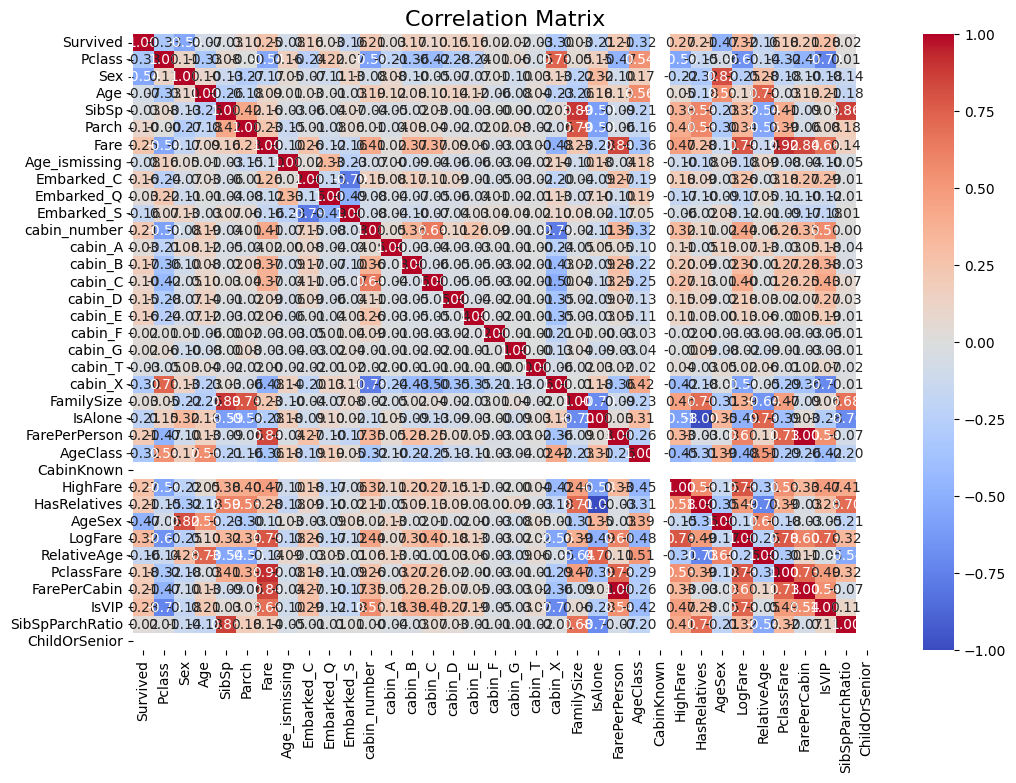

In [72]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Calculate the correlation matrix
corr_matrix = train_data.corr()

# Set up the matplotlib figure
plt.figure(figsize=(12, 8))

# Draw the heatmap with Seaborn
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)

# Title and display the plot
plt.title('Correlation Matrix', fontsize=16)
plt.show()

In [73]:
Y_train = train_data['Survived']
train_data.drop('Survived', axis=1, inplace=True)

Y_cv = cv_data['Survived']
cv_data.drop('Survived', axis=1, inplace=True)

test_data.drop('Survived', axis=1, inplace=True)

In [89]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

# Define the model
model = Sequential([
    Dense(128, activation='relu', input_shape=(train_data.shape[1],)),  # Input layer
    BatchNormalization(),
    Dropout(0.5),  # Dropout for regularization

    Dense(64, activation='relu'),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.5),

    Dense(128, activation='relu'),  # Hidden layer 1
    BatchNormalization(),
    Dropout(0.5),

    Dense(32, activation='relu'),  # Hidden layer 2
    BatchNormalization(),
    Dropout(0.5),

    Dense(1, activation='sigmoid')  # Output layer for binary classification
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001),
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Train the model
history = model.fit(train_data, Y_train, epochs=300, batch_size=64,
                    validation_data=(cv_data, Y_cv), verbose=1)

Epoch 1/300


/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


13/13 ━━━━━━━━━━━━━━━━━━━━ 11s 354ms/step - accuracy: 0.5255 - loss: 0.9588 - val_accuracy: 0.6023 - val_loss: 0.7464
Epoch 2/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step - accuracy: 0.5755 - loss: 0.8158 - val_accuracy: 0.6364 - val_loss: 0.6658
Epoch 3/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.5543 - loss: 0.8504 - val_accuracy: 0.7614 - val_loss: 0.6227
Epoch 4/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5858 - loss: 0.8100 - val_accuracy: 0.7614 - val_loss: 0.5931
Epoch 5/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5743 - loss: 0.8819 - val_accuracy: 0.7614 - val_loss: 0.5833
Epoch 6/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.5945 - loss: 0.8010 - val_accuracy: 0.7614 - val_loss: 0.5733
Epoch 7/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5893 - loss: 0.7827 - val_accuracy: 0.7614 - val_loss: 0.5625
Epoch 8/300
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.6156 - loss: 0.7312 - val_accuracy: 0.7500 - val_loss: 

In [77]:
# Flatten the predictions to 1D if they are not already
preds = model.predict(test_data).flatten()

# Prepare the output DataFrame
output = pd.DataFrame({'PassengerId': passenger_id_test, 'Survived': preds})

# Convert probabilities to binary (0 or 1) if required for binary classification
output['Survived'] = (output['Survived'] > 0.5).astype(int)

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='PassengerId', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions_DNN.csv', index=False)

# Download the file (for use in Google Colab or Jupyter)
from google.colab import files
files.download('predictions_DNN.csv')


14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [78]:
# Check what GPU is available in Google Colab
!nvidia-smi

# Define parameter search space
search_spaces = {
    'learning_rate': Real(0.001, 0.5, 'uniform'),
    'max_depth': Integer(1, 70),
    'n_estimators': Integer(100, 900),
    'subsample': Real(0.5, 1.0, 'uniform'),
    'colsample_bytree': Real(0.5, 1.0, 'uniform'),
    'gamma': Real(0, 10, 'uniform'),
}

# Initialize the XGBClassifier model with GPU support
model = xgb.XGBClassifier(
    objective='binary:logistic',  # Use for binary classification
    tree_method='gpu_hist',  # Use GPU for training
    verbosity=2
)

kf = KFold(n_splits=5)  # 10-fold cross-validation

# Using 'accuracy' as the scoring metric (can be changed to roc_auc, f1, etc.)
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=32,
    cv=kf,
    scoring='accuracy',  # Use classification accuracy as the scoring metric
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using X_train and y_train (classification labels, not log-transformed)
optimizer.fit(train_data, Y_train)

# Get the best model
best_model = optimizer.best_estimator_

# Get cross-validation results
cv_results = optimizer.cv_results_

# Print best parameters and mean accuracy
mean_accuracy = cv_results['mean_test_score']  # Mean accuracy for each fold

print(f"Best parameters: {optimizer.best_params_}")
print(f"Mean Cross-validation Accuracy: {mean_accuracy.mean():.4f}")
print(f"Cross-validation Accuracy for each iteration: {mean_accuracy}")

print("Optimization complete. Best XGBoost classifier model saved.")


Wed Oct 30 12:52:46 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   74C    P0              31W /  70W |    261MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:158: UserWarning: [12:55:45] WARNING: /workspace/src/common/error_msg.cc:27: The tree method `gpu_hist` is deprecated since 2.0.0. To use GPU training, set the `device` parameter to CUDA instead.

    E.g. tree_method = "hist", device = "cuda"

  warnings.warn(smsg, UserWarning)


Best parameters: OrderedDict([('colsample_bytree', 0.717350589277564), ('gamma', 8.776452788949316), ('learning_rate', 0.05913951054348178), ('max_depth', 2), ('n_estimators', 306), ('subsample', 0.7458648977608326)])
Mean Cross-validation Accuracy: 0.8024
Cross-validation Accuracy for each iteration: [0.81275621 0.81025621 0.81024068 0.81274845 0.81149068 0.81522516
 0.81524845 0.81645963 0.82023292 0.81148292 0.81650621 0.7878028
 0.79154503 0.78901398 0.81150621 0.81525621 0.81521739 0.60792702
 0.81397516 0.78276398 0.79781832 0.80025621 0.82021739 0.82021739
 0.81150621 0.80401398 0.7890528  0.81024845 0.81646739 0.81774068
 0.80649068 0.81522516]
Optimization complete. Best XGBoost classifier model saved.


In [81]:
# Make predictions using the best model directly on test_data
preds = best_model.predict(test_data)

# Prepare the output DataFrame
output = pd.DataFrame({'PassengerId': passenger_id_test, 'Survived': preds})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='PassengerId', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions_XGB.csv', index=False)
files.download('predictions_XGB.csv')


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold
from skopt import BayesSearchCV
from skopt.space import Real, Integer

# Define parameter search space for Random Forest
search_spaces = {
    'n_estimators': Integer(100, 900),
    'max_depth': Integer(1, 70),
    'max_features': Real(0.5, 1.0, 'uniform'),
    'min_samples_split': Integer(2, 20),
    'min_samples_leaf': Integer(1, 20),
}

# Initialize the RandomForestClassifier model
model = RandomForestClassifier()

kf = KFold(n_splits=5)  # 5-fold cross-validation

# Using 'accuracy' as the scoring metric
optimizer = BayesSearchCV(
    estimator=model,
    search_spaces=search_spaces,
    n_iter=32,
    cv=kf,
    scoring='accuracy',  # Use classification accuracy as the scoring metric
    verbose=1,
    n_jobs=-1,
    return_train_score=True
)

# Fit the optimizer using train_data and Y_train
optimizer.fit(train_data, Y_train)

# Get the best model
best_model_RF = optimizer.best_estimator_

# Get cross-validation results
cv_results = optimizer.cv_results_

# Print best parameters and mean accuracy
mean_accuracy = cv_results['mean_test_score']  # Mean accuracy for each fold

print(f"Best parameters: {optimizer.best_params_}")
print(f"Mean Cross-validation Accuracy: {mean_accuracy.mean():.4f}")
print(f"Cross-validation Accuracy for each iteration: {mean_accuracy}")

print("Optimization complete. Best Random Forest model saved.")


Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fits
Fitting 5 folds for each of 1 candidates, totalling 5 fi

In [84]:
# Make predictions using the best model directly on test_data
preds = best_model_RF.predict(test_data)

# Prepare the output DataFrame
output = pd.DataFrame({'PassengerId': passenger_id_test, 'Survived': preds})

# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='PassengerId', keep='first', inplace=True)

# Save predictions to a CSV file
output.to_csv('predictions_RF.csv', index=False)
files.download('predictions_RF.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Compare the accuracy of the models on the CV set

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step


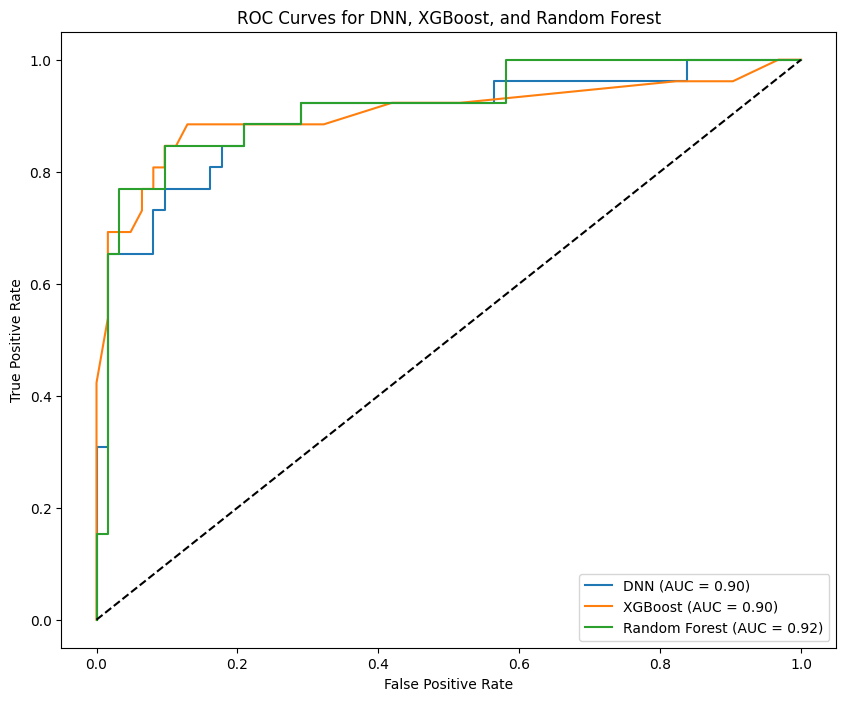

In [91]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Generate predicted probabilities for the positive class (1) for each model
# (Assuming you have test_data and Y_test for evaluation)
xgb_probs = best_model.predict_proba(cv_data)[:, 1]  # XGB model
rf_probs = best_model_RF.predict_proba(cv_data)[:, 1]  # Random Forest model
dnn_probs = model.predict(cv_data).flatten()  # DNN model


# Calculate ROC curves and AUC scores for each model
fpr_dnn, tpr_dnn, _ = roc_curve(Y_cv, dnn_probs)
roc_auc_dnn = auc(fpr_dnn, tpr_dnn)

fpr_xgb, tpr_xgb, _ = roc_curve(Y_cv, xgb_probs)
roc_auc_xgb = auc(fpr_xgb, tpr_xgb)

fpr_rf, tpr_rf, _ = roc_curve(Y_cv, rf_probs)
roc_auc_rf = auc(fpr_rf, tpr_rf)

# Plotting the ROC curves
plt.figure(figsize=(10, 8))
plt.plot(fpr_dnn, tpr_dnn, label=f'DNN (AUC = {roc_auc_dnn:.2f})')
plt.plot(fpr_xgb, tpr_xgb, label=f'XGBoost (AUC = {roc_auc_xgb:.2f})')
plt.plot(fpr_rf, tpr_rf, label=f'Random Forest (AUC = {roc_auc_rf:.2f})')

# Plot the random chance line
plt.plot([0, 1], [0, 1], 'k--')

# Adding labels and legend
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for DNN, XGBoost, and Random Forest')
plt.legend(loc='lower right')
plt.show()


In [98]:
xgb_pred = best_model.predict(cv_data)  # XGB model
rf_pred = best_model_RF.predict(cv_data)  # Random Forest model
dnn_pred = model.predict(cv_data).flatten()  # DNN model

# Prepare the output DataFrame
output = pd.DataFrame({'PassengerId': passenger_id_cv, 'Survived': Y_cv, 'Survived_XGB': xgb_pred, 'Survived_RF': rf_pred, 'Survived_DNN': dnn_pred})
output['Survived_DNN'] = (output['Survived_DNN'] > 0.5).astype(int)
# Remove any duplicate rows by 'PassengerId'
output.drop_duplicates(subset='PassengerId', keep='first', inplace=True)

output.to_csv('predictions_cv.csv', index=False)
files.download('predictions_cv.csv')

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>